/home/user/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


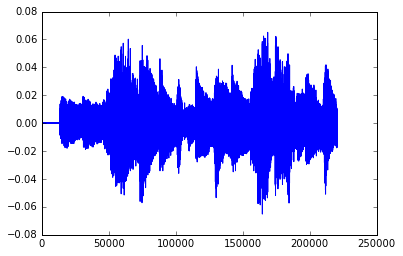

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import zounds
import requests
from io import BytesIO

# fetch some audio of a Bach piece from Internet Archive
url = 'https://ia802606.us.archive.org/9/items/AOC11B/onclassical_luisi_bach_partita_B-flat-major_bwv-825_1.ogg'
resp = requests.get(url, stream=True)
bio = BytesIO(resp.content)


# load and decode the audio samples
samples = zounds.AudioSamples.from_file(bio)
# take a slice of the first five seconds
samples = samples[:zounds.Seconds(5)]
# convert to mono
samples = samples.mono

plt.plot(samples)
import IPython.display as ipd
ipd.Audio(samples, rate=int(samples.samplerate))

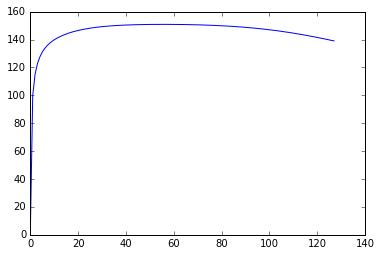

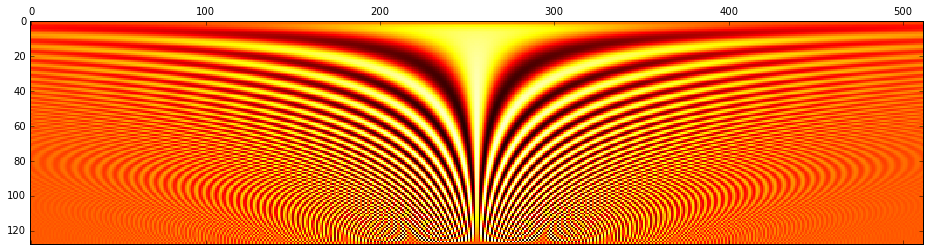

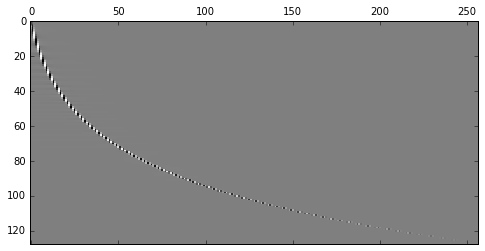

In [3]:
from scipy.signal import morlet
import numpy as np

# TODO: start with constant scaling factor, compute windowed and pytorch spectrograms, then move on to 
# variable scaling factors

# M = window size
# r = sampling rate

# f_hz = 2 * s * w * r / M

# assuming a scaling factor of 1
# f_hz = 2 * w * r / M

# 440 = 2 * w * 11025 / 512
# (440 / w) = 2 * 11025 / 512
# (440 / w) = 43.
# 440 = 43 * w

# w (f in samples) = f_hz / (2 * 11025 / 512)



def make_filter_bank(samplerate, kernel_size, scale):
    """
    Create a bank of finite impulse response filters, with
    frequencies centered on the sub-bands of scale
    """
    basis_size = len(scale)
    basis = np.zeros((basis_size, kernel_size), dtype=np.complex128)
    scaling_factors = np.geomspace(0.25, 0.5, len(scale))
    for i, band in enumerate(scale):
        scaling = scaling_factors[i]
        basis[i] = morlet(
            M=kernel_size,  # wavelet size
            w=band.center_frequency / (scaling * 2 * int(samplerate) / kernel_size),  # time-frequency resolution tradeoff
            s=scaling)  # scaling factor
    return basis


samplerate = samples.samplerate
channels = 128
kernel_size = 512
scale = zounds.MelScale(zounds.FrequencyBand(1, samplerate.nyquist), channels)

# give each filter unit norm
filter_bank = make_filter_bank(samplerate, kernel_size, scale)
filter_bank /= np.linalg.norm(filter_bank, axis=-1, keepdims=True) + 1e-8

# apply perceptual weighting
weighting = zounds.AWeighting()
data = weighting._wdata(scale)
filter_bank *= data[:, None]

plt.plot(np.linalg.norm(filter_bank, axis=-1))

plt.matshow(filter_bank.real, cmap='hot')

coeffs = np.fft.rfft(filter_bank.real)
plt.matshow(coeffs.real, cmap='gray')

(861, 512) (128, 512)


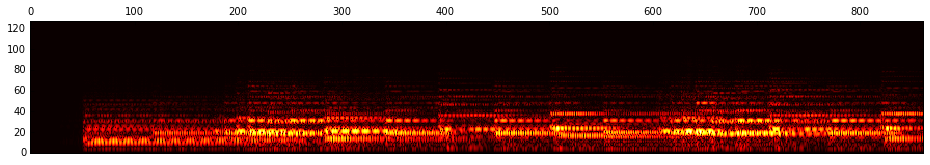

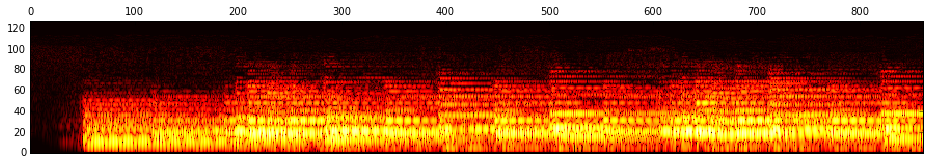

In [4]:
windowed = samples.sliding_window(zounds.SampleRate(
        frequency=samplerate.frequency * (kernel_size // 2),
        duration=samplerate.frequency * kernel_size))


def perceptual(x):
    x = np.abs(x.real)
    x = 20 * np.log10(x + 1)
    return x

def naive_conv(x, filter_bank):
    return np.dot(x, filter_bank.real.T)

def fft_conv(x, filter_bank):
    print x.shape, filter_bank.shape
    window = np.hamming(x.shape[-1])
    
    windowed_freq = np.fft.rfft(x * window)
    filter_bank_freq = np.fft.rfft(filter_bank.real * window)
    
    spec = np.dot(windowed_freq, filter_bank_freq.T)
    return spec.real

naive_spec = perceptual(naive_conv(windowed, filter_bank))
fft_spec = perceptual(fft_conv(windowed, filter_bank))


plt.matshow(naive_spec.T, origin='lower', cmap='hot')
plt.matshow(fft_spec.T, origin='lower', cmap='hot')

torch.Size([1, 128, 220502]) torch.Size([1, 128, 862])


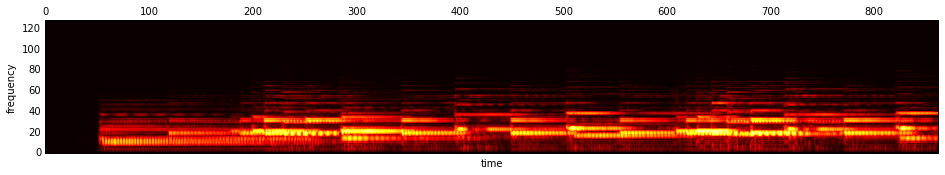

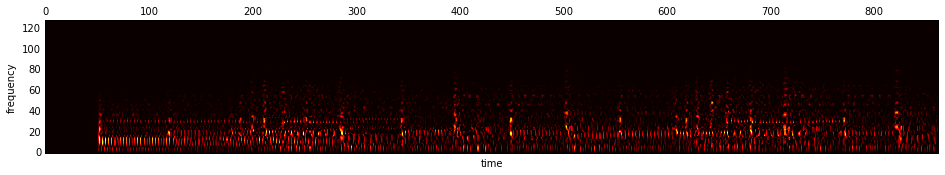

In [21]:
import torch
from torch.nn import functional as F

# convert our filter bank to a PyTorch tensor
weights = torch.from_numpy(filter_bank.real)\
    .view(len(scale), 1, kernel_size)\
    .float()

# convert the raw audio samples to a PyTorch tensor
tensor_samples = torch\
    .from_numpy(samples)\
    .view(1, 1, -1)\
    .float()

# convolve the filter bank with the samples
spectral = F.conv1d(tensor_samples, weights, padding=weights.shape[-1] // 2)

# compute log-scale magnitudes
spectral = F.relu(spectral)
spectral = 20 * torch.log10(spectral + 1)

# pool over short, overlapping windows, discarding phase
# information
pooled = F.avg_pool1d(
    spectral, 
    kernel_size=512, 
    stride=256, 
    padding=256)

print spectral.shape, pooled.shape
first_order = spectral - F.upsample(pooled, scale_factor=256)[..., :spectral.shape[-1]]

# pool over short, overlapping windows, discarding phase
# information
pooled2 = F.avg_pool1d(
    first_order, 
    kernel_size=512, 
    stride=256, 
    padding=256)
pooled2 = F.relu(pooled2)

pooled = pooled.data.cpu().numpy().squeeze()
plt.matshow(pooled, cmap='hot', origin='lower')
plt.xlabel('time')
plt.ylabel('frequency')

pooled2 = pooled2.data.cpu().numpy().squeeze()
plt.matshow(pooled2, cmap='hot', origin='lower')
plt.xlabel('time')
plt.ylabel('frequency')